# Correlation of RAI to Eth price moves - Data as of 3-29-2021

We are performing a vector autogression in order to determine if a casual or multi-casual relationship exists between Eth and Rai price moves. This will help use understand system level price dynamics of the Rai system.  

### Vector Autoregression 

Vector autoregression (VAR) is a type of statistical model used to capture the relationship between multiple time series signals as they change over time. VAR models are extensions of univariate autoregression models allowing for multivariate time series analysis.

Autogregressive models use lagged past values of the variable and have an order based on how many times the variable has been lagged, i.e. VAR(2) means two lagged values. Lagged values help to determine if seasonality or reoccuring patterns exist in the data. 

A pth-order VAR model is written as:
$$y_t = c + A_1 y_{t-1} + A_2 y_{t-2} + \cdots + A_p y_{t-p} + e_t,$$

In vector notation, a VAR(1) with 2 variables is:

$$\begin{bmatrix}y_{1,t} \\ y_{2,t}\end{bmatrix} = \begin{bmatrix}c_{1} \\ c_{2}\end{bmatrix} + \begin{bmatrix}a_{1,1}&a_{1,2} \\ a_{2,1}&a_{2,2}\end{bmatrix}\begin{bmatrix}y_{1,t-1} \\ y_{2,t-1}\end{bmatrix} + \begin{bmatrix}e_{1,t} \\ e_{2,t}\end{bmatrix}$$


For our VAR model, we will have a vector of prices, $P$ of EthRai(marketPriceEth),RaiUSD(marketPriceUsd), and EthUSD price moves.


#### Assumptions:
* Every error term has a mean of zero and is normally distributed.
* Variables are stationary. Differenceing can be used to make the data stationary.
* Data is on the same scale

### Other methods with fewer assumptions

Non-parametric Bayesian VAR models have been under development and appear to perform well and can operate on nonlinear relationship, heteroscedasticity, and non Gaussian error data[1,2].

Another popular time series analysis modeling technique is the Autorgressive Integrated Moving Average (ARIMA) model. These models are often used in forecasting or when the data shoes evidence of non-stationarity. For multiple time series vectors, like we have here, extensions of the ARIMA model are available, such ARIMAX model that has exogenous variable inputs. ARIMAX models do not have an assumption of Gaussian errors as it uses a maximum likelihood estimation function to fit.

#### References
- 1 Kalli, Maria & Griffin, Jim E., 2018. "Bayesian nonparametric vector autoregressive models," Journal of Econometrics, Elsevier, vol. 203(2), pages 267-282.
- 2 Jeliazkov, Ivan. (2013). Nonparametric Vector Autoregressions: Specification, Estimation, and Inference. Advances in Econometrics. 33. 10.1108/S0731-9053(2013)0000031009. 


We have taken the trade off in assumption for this first version correlation model vs a non-parametric approach for simplicity sake, that current robust python VAR implementations exist, and for illustrative purposes around the concepts we are addressing.


In [945]:
# import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt


## Data

We import the data obtained in the [TheGraphDataSetCreation](TheGraphDataSetCreation.ipynb) notebook and preprocess it.

In [946]:
graphData = pd.read_csv('saved_results/RaiLiveGraphData.csv')
del graphData['Unnamed: 0']

In [947]:
graphData.head()

,blockNumber,erc20CoinTotalSupply,globalDebt,redemptionPrice,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,...,globalDebtCeiling,systemSurplus,totalActiveSafeCount,wethAddress,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,error,error_integral
0,11857308,1988.440433,1988.577499,"{'block': '11849022', 'id': '0xe313271188492c4...",1613338681,3.14,3.14,0.002589,4.670500,0,...,115792089237316195423570985008687.9,0.068533,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,-1.530500,-1.530500
1,11860793,2788.440433,2788.617717,"{'block': '11860755', 'id': '0x40066774f6fb7d3...",1613384616,3.14,3.14,0.002481,4.377049,0,...,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,-1.237049,-2.767550
2,11861040,2788.440433,2788.657935,"{'block': '11861008', 'id': '0x0d551e2a2d55fa8...",1613387890,3.14,3.14,0.002481,4.406833,0,...,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,-1.266833,-4.034383
3,11861337,2788.440433,2788.657935,"{'block': '11861237', 'id': '0x5c67dbb323db039...",1613392101,3.14,3.14,0.002481,4.419266,0,...,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,-1.279266,-5.313648
4,11861474,3048.440433,3048.645955,"{'block': '11861237', 'id': '0x5c67dbb323db039...",1613394096,3.14,3.14,0.001769,3.194330,0,...,115792089237316195423570985008687.9,0.116162,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,-0.054330,-5.367978


### Exploratory Analysis

In [948]:
graphData.describe()

,blockNumber,erc20CoinTotalSupply,globalDebt,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,debtCeiling,...,Eth_price,debtAvailableToSettle,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,error,error_integral
count,9.680000e+02,9.680000e+02,9.680000e+02,9.680000e+02,968.000000,968.000000,968.000000,968.000000,968.000000,9.680000e+02,...,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000
mean,1.199348e+07,3.423472e+07,3.465959e+07,1.615150e+09,3.060915,3.060915,0.001870,3.186711,0.026860,4.486159e+07,...,1717.188493,292230.574902,112253.419544,811.109504,0.819082,0.999963,0.999708,3.060914,-0.125796,-112.290311
std,7.731615e+04,1.358602e+07,1.368873e+07,1.028748e+06,0.047792,0.047792,0.000284,0.425674,0.216443,1.559874e+07,...,148.005290,364865.156104,67166.517314,264.657786,0.355755,0.000060,0.000481,0.047790,0.402777,29.020842
min,1.185731e+07,1.988440e+03,1.988577e+03,1.613339e+09,3.013686,3.013686,0.001600,2.850455,0.000000,1.000000e+07,...,1328.192602,0.000000,-8000.336813,3.000000,0.168066,0.999796,0.998373,3.013686,-4.915382,-137.479740
25%,1.192674e+07,3.212887e+07,3.247190e+07,1.614261e+09,3.018242,3.018242,0.001675,2.985433,0.000000,3.996953e+07,...,1598.529399,23588.941750,38636.810709,785.000000,0.514742,0.999924,0.999394,3.018267,-0.161181,-134.382143
50%,1.199251e+07,3.563782e+07,3.650929e+07,1.615136e+09,3.031328,3.031328,0.001773,3.098964,0.000000,4.686430e+07,...,1755.372733,45752.103558,146261.966787,849.500000,0.866781,0.999984,0.999869,3.031328,-0.051953,-124.723091
75%,1.205953e+07,4.378923e+07,4.462623e+07,1.616029e+09,3.108695,3.108695,0.002030,3.247577,0.000000,5.727986e+07,...,1819.556530,666376.609641,162449.549871,1004.000000,1.107615,1.000012,1.000093,3.108695,0.037768,-96.128266
max,1.212903e+07,4.899876e+07,4.918825e+07,1.616953e+09,3.140000,3.140000,0.004474,8.055382,3.000000,5.727986e+07,...,2032.578356,943944.359793,178819.337222,1021.000000,1.562592,1.000051,1.000408,3.140000,0.289543,-1.530500


In [949]:
graphData.columns

Index(['blockNumber', 'erc20CoinTotalSupply', 'globalDebt', 'redemptionPrice',
       'timestamp', 'hourlyredemptionPriceActual',
       'hourlyredemptionRateActual', 'hourlymarketPriceEth',
       'hourlymarketPriceUsd', 'activeLiquidations', 'currentFsmUpdate',
       'currentMedianizerUpdate', 'debtCeiling', 'liquidationsStarted',
       'totalAnnualizedStabilityFee', 'totalCollateral', 'Eth_price',
       'coinAddress', 'coinUniswapPair', 'currentCoinMedianizerUpdate',
       'debtAvailableToSettle', 'globalDebtCeiling', 'systemSurplus',
       'totalActiveSafeCount', 'wethAddress', 'RedemptionRateAnnualizedRate',
       'RedemptionRateHourlyRate', 'RedemptionRateEightHourlyRate',
       'RedemptionPrice', 'error', 'error_integral'],
      dtype='object')

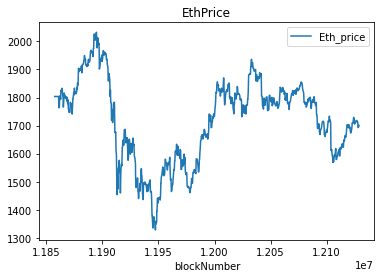

In [950]:
graphData.plot(x='blockNumber',y='Eth_price',kind='line',title='EthPrice')

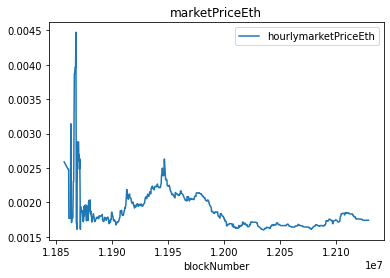

In [951]:
graphData.plot(x='blockNumber',y='hourlymarketPriceEth',kind='line',title='marketPriceEth')

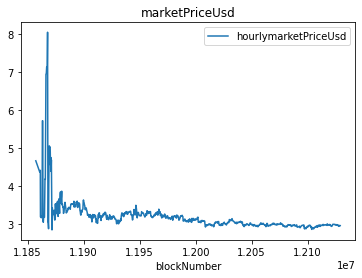

In [952]:
graphData.plot(x='blockNumber',y='hourlymarketPriceUsd',kind='line',title='marketPriceUsd')

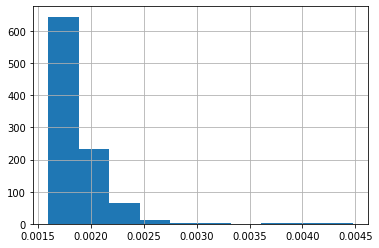

In [953]:
graphData.hourlymarketPriceEth.hist()

Due to the large spikes the market prices during the system initialization, we will cut out the first 100 observations.

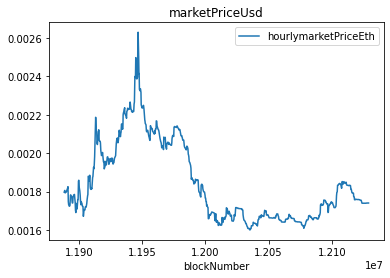

In [954]:
graphData[100:].plot(x='blockNumber',y='hourlymarketPriceEth',kind='line',title='marketPriceUsd')

In [955]:
# subset data to vector for VAR
P = graphData[100:][['hourlymarketPriceEth','hourlymarketPriceUsd','Eth_price']]

In [956]:
P.describe()

,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price
count,868.000000,868.000000,868.000000
mean,0.001844,3.111245,1702.971060
std,0.000205,0.155137,148.443585
min,0.001600,2.864213,1328.192602
25%,0.001671,2.980661,1581.747352
50%,0.001758,3.069784,1716.820212
75%,0.002030,3.220284,1808.762864
max,0.002631,3.639484,2032.578356


### Data Transformations

We will take the log of the data to reduce the skewness and take the first difference to make the data stationary, meaning that the distribution does not change when shifted by tie.

In [957]:
## Difference and log values
P['marketPriceEth_log_differenced'] = np.log(P['hourlymarketPriceEth']).diff()
P['marketPriceUsd_log_differenced'] = np.log(P['hourlymarketPriceUsd']).diff()
P['Eth_price_log_differenced'] = np.log(P['Eth_price']).diff()

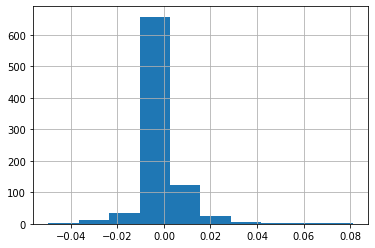

In [958]:
P.marketPriceEth_log_differenced.hist()

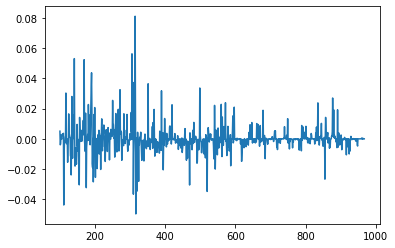

In [959]:
P.marketPriceEth_log_differenced.plot()

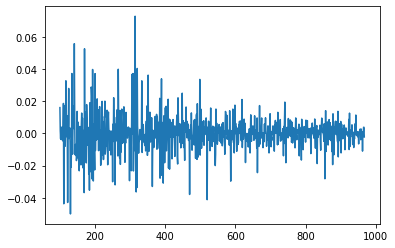

In [960]:
P.marketPriceUsd_log_differenced.plot()

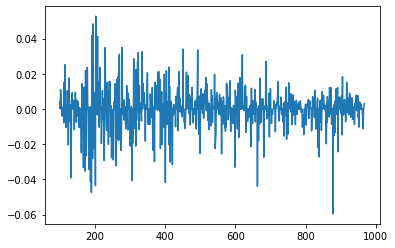

In [961]:
P.Eth_price_log_differenced.plot()

In [962]:
P.describe()

,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,marketPriceEth_log_differenced,marketPriceUsd_log_differenced,Eth_price_log_differenced
count,868.000000,868.000000,868.000000,867.000000,867.000000,867.000000
mean,0.001844,3.111245,1702.971060,-0.000037,-0.000183,-0.000144
std,0.000205,0.155137,148.443585,0.009102,0.011093,0.010949
min,0.001600,2.864213,1328.192602,-0.049693,-0.050115,-0.059595
25%,0.001671,2.980661,1581.747352,-0.002318,-0.004204,-0.002691
50%,0.001758,3.069784,1716.820212,-0.000051,0.000000,0.000000
75%,0.002030,3.220284,1808.762864,0.000835,0.004136,0.003933
max,0.002631,3.639484,2032.578356,0.081117,0.072969,0.052679


Standardize the data (rescale values to mean of a 0 and a standard deviation of 1). Standardization will move these different scales/order of magnitude to the same. 

In [963]:
# scaler objects
scalers = []
# features to scale
features = ['marketPriceEth_log_differenced','marketPriceUsd_log_differenced','Eth_price_log_differenced']
for i in features:
    # train the standardization
    scaler = StandardScaler()
    # prepare data for standardization
    values = P[i].values
    values = values.reshape((len(values), 1))
    scaler = scaler.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
    scalers.append(scaler)
    string = i + '_standardized'
    P[string] = scaler.transform(values)

Mean: -0.000037, StandardDeviation: 0.009097
Mean: -0.000183, StandardDeviation: 0.011086
Mean: -0.000144, StandardDeviation: 0.010943


The following code can be used to inverse the transform
```
inversed = scaler.inverse_transform(normalized)
```

In [964]:
P.describe()

,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,marketPriceEth_log_differenced,marketPriceUsd_log_differenced,Eth_price_log_differenced,marketPriceEth_log_differenced_standardized,marketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized
count,868.000000,868.000000,868.000000,867.000000,867.000000,867.000000,8.670000e+02,8.670000e+02,8.670000e+02
mean,0.001844,3.111245,1702.971060,-0.000037,-0.000183,-0.000144,-1.068946e-17,-8.707632e-18,3.265362e-17
std,0.000205,0.155137,148.443585,0.009102,0.011093,0.010949,1.000577e+00,1.000577e+00,1.000577e+00
min,0.001600,2.864213,1328.192602,-0.049693,-0.050115,-0.059595,-5.458815e+00,-4.503979e+00,-5.432846e+00
25%,0.001671,2.980661,1581.747352,-0.002318,-0.004204,-0.002691,-2.507516e-01,-3.626638e-01,-2.327996e-01
50%,0.001758,3.069784,1716.820212,-0.000051,0.000000,0.000000,-1.565147e-03,1.652394e-02,1.312597e-02
75%,0.002030,3.220284,1808.762864,0.000835,0.004136,0.003933,9.584611e-02,3.895753e-01,3.725767e-01
max,0.002631,3.639484,2032.578356,0.081117,0.072969,0.052679,8.921413e+00,6.598478e+00,4.827050e+00


In [965]:
P.dropna(inplace=True)

As a final check prior to modeling, we will run the Augmented Dickey-Fuller test to ensure that our data is stationary (non-unit root - A unit root is a stochastic trend in a time series). The test's hypothesis are:


* $H_O: \textrm{Time series has a unit root}$
* $H_A: \textrm{Time series does not have a unit root}$

In [966]:

for i in features:
    print(i)
    result = adfuller(P[i].values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        decision = "fail to reject - unit root present"
    else:
        decision = "reject, no unit root present"
    print(decision)
    print('----------------------------------')

marketPriceEth_log_differenced
ADF Statistic: -8.770159
p-value: 0.000000
reject, no unit root present
----------------------------------
marketPriceUsd_log_differenced
ADF Statistic: -10.593379
p-value: 0.000000
reject, no unit root present
----------------------------------
Eth_price_log_differenced
ADF Statistic: -8.883609
p-value: 0.000000
reject, no unit root present
----------------------------------


Based on the Augmented Dickey-Fuller, our preprocessing was successful and none of our univariate time series signals as a unit root. We can now proceed to the VAR model.

## Fit model

In [967]:
# instantiate the var model object from statsmodels
model = VAR(P[['marketPriceEth_log_differenced_standardized',
               'marketPriceUsd_log_differenced_standardized',
               'Eth_price_log_differenced_standardized']])

/home/aclarkdata/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [968]:
# calculate the best autocorrelation value
results = model.fit(maxlags=15, ic='aic')

In [969]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 28, Mar, 2021
Time:                     14:47:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.559981
Nobs:                     852.000    HQIC:                  -1.03443
Log likelihood:          -2922.67    FPE:                   0.264837
AIC:                     -1.32896    Det(Omega_mle):        0.226187
--------------------------------------------------------------------
Results for equation marketPriceEth_log_differenced_standardized
                                                     coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------
const                                                   0.001681         0.031691            0.053           0.958
L

The Akaike information criterion(AIC) is used to evaluate how well a model fits the data. It penalizes for more independent variables to try to prevent over-fitting. AIC is calculated by the maximum log-likelihood of the model and the number of parameters (K) used to reach that likelihood. The AIC function is 2K – 2(log-likelihood).

Lower AIC values indicate a better-fit model, and a model with a delta-AIC (the difference between the two AIC values being compared) of more than -2 is considered significantly better than the model it is being compared to.

- https://www.scribbr.com/statistics/akaike-information-criterion/

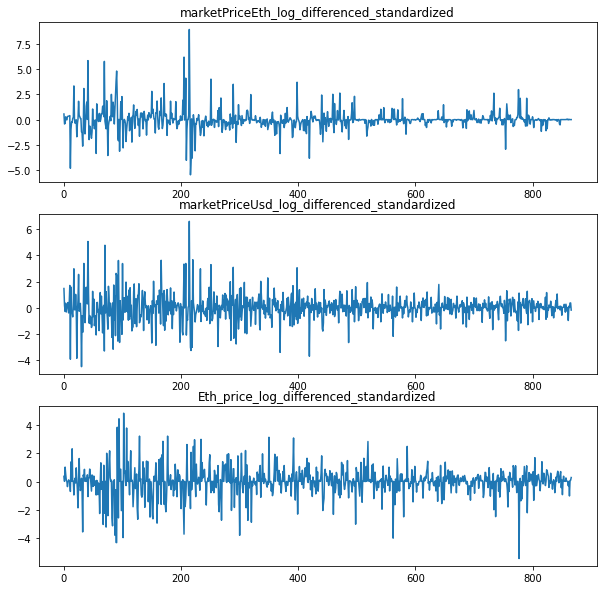

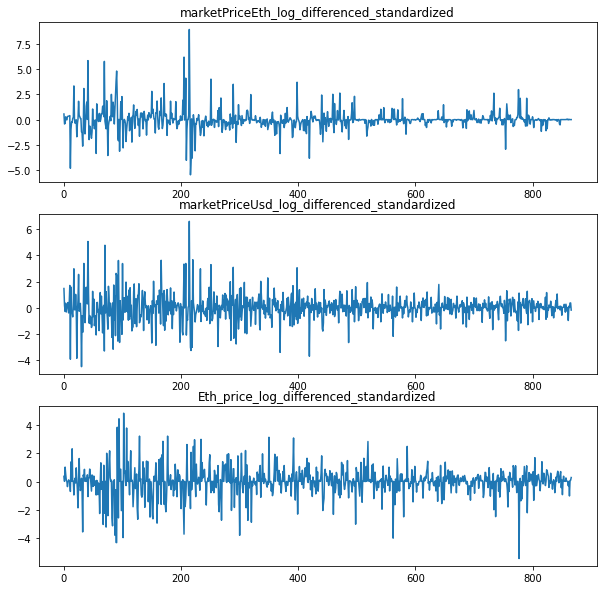

In [970]:
results.plot()

## Granger causality

Granger causality is a hypothesis test for determining whether one time series is useful in forecasting another. We can say that a variable X, or variables, evolves over time Granger-causes another evolving variable Y if predictions of the value of Y based on its own past values and on the past values of X are better than predictions of Y based only on Y's own past values.


In our analysis, we present the hypothesis that Eth is a driver of Rai market price. In statistical parlance, we have the following:

* $H_O: \textrm{Eth price does not Granger cause Rai market price}$
* $H_A: \textrm{Eth price does Granger cause Rai market price}$

We will perform now perform the Granger Causality hypothesis test with an $\alpha = 0.05$ value using an F test to determine if the eth price has any casual component for predicting the Rai market price. If the p-value (the probability of obtaining test results at least as extreme as the results actually observed) of the test is less than or equal to $\alpha$ we will reject the null hypothesis and determine that Eth price is a driver of Rai market price.

In [971]:
results.test_causality(['marketPriceEth_log_differenced_standardized', 
                        'marketPriceUsd_log_differenced_standardized'],
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
2.856,1.464,0.000,"(30, 2418)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price.

In [972]:
results.test_causality('marketPriceEth_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
2.562,1.671,0.001,"(15, 2418)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price in Eth.

In [973]:
results.test_causality('marketPriceUsd_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
2.593,1.671,0.001,"(15, 2418)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price in Usd.

## Impulse Response (Shock) Analysis

Impulse response is used in econometrics and macroeconomic modeling to study how the system reacts to unit exogenous shocks. In signal processing, an impulse response is the reaction of a dynamic system in response to some external change. The Impulse response below is the estimated responses of a variable to a unit impulse.

In [974]:
# 50 periods
irf = results.irf(50)

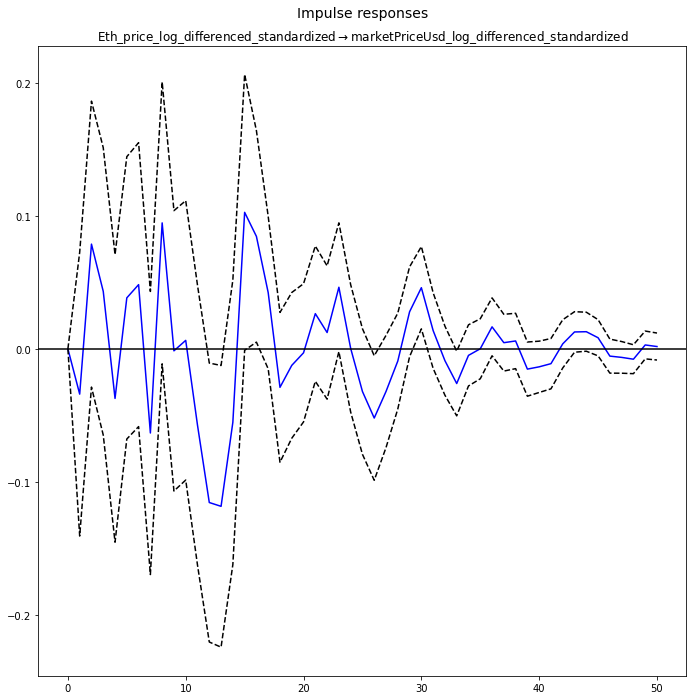

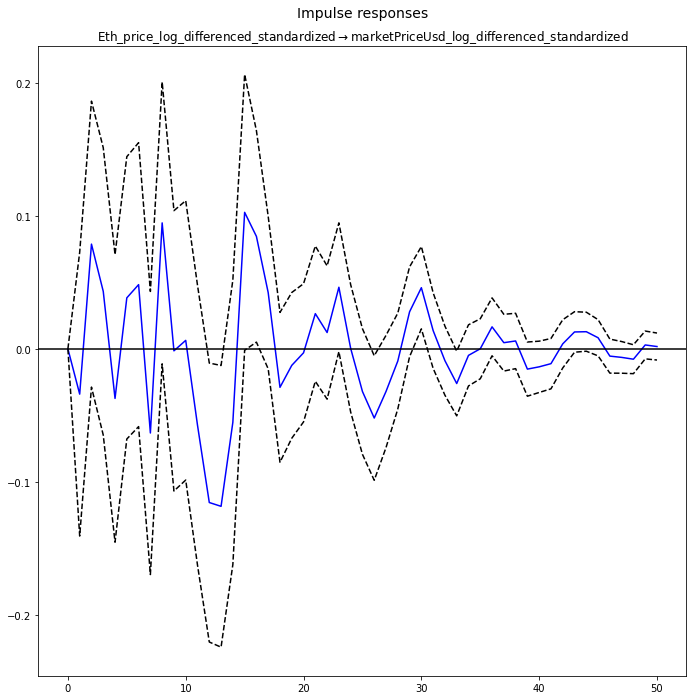

In [975]:
irf.plot(impulse='Eth_price_log_differenced_standardized', #variable providing the unit impulse
         response='marketPriceUsd_log_differenced_standardized', # variable affected by the impulse
         plot_stderr = True, #Plot standard impulse response error bands
        repl=1000) #Number of replications for Monte Carlo and Sims-Zha standard errors

Standard errors are plotted by default at the 95% significance level.

## Correlation Analysis

,marketPriceEth_log_differenced_standardized,marketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized
marketPriceEth_log_differenced_standardized,1.000000,0.386231,-0.174121
marketPriceUsd_log_differenced_standardized,0.386231,1.000000,-0.080395
Eth_price_log_differenced_standardized,-0.174121,-0.080395,1.000000


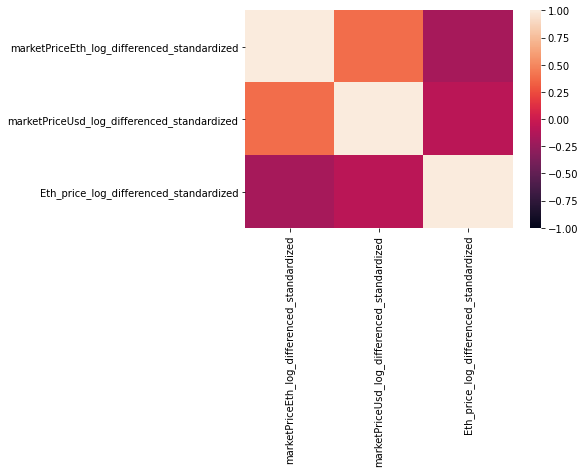

In [976]:
corr = P[['marketPriceEth_log_differenced_standardized',
          'marketPriceUsd_log_differenced_standardized',
          'Eth_price_log_differenced_standardized']].corr()
corr_cols = corr.columns
ax = sns.heatmap(corr, vmax=1.0, vmin=-1.0);
corr

Using Pearson's correlation, we have a -0.174121.

## Next steps

* Sensativity checking casuality results with and without standardization.
* **Validation of the relationship between the redemption rate to redemption price and error to redemption rate.**
* ### New variables to add:
    * Error 
    * Redemption rate 
    * Uniswap RAI balance relative to total RAI supply - RAI in Uniswap V2 (RAI/ETH) /  Outstanding RAI numerator.
    * Rai supply/Rai cap (max debt ceiling) - From dashboard - Outstanding RAI. Numerator and Denominator are the same.
    * ETH locked in collateral - Total ETH Locked
    * Collateralization ratio - (Total ETH Locked * Value of Eth in USD) / (Total Rai outstanding * value of Rai in USD) - Denominator is the redemption price - Right equations
    * Add lagged Eth value (1 hour) - get timestamps and do diffs and map to seconds. Plot histogram of seconds per interval. Representation of times.
* Goal is to make some statements about how Rai is actually being dictated by Ethereum price moves.

## Conclusion

Based on our VAR analysis, validating our hypothesis, Eth price does have an influence on the Rai price.